In [1]:
import os
import importlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import hydra
import sklearn.metrics
import seaborn


In [2]:
with hydra.initialize(config_path="conf"):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "victim=mnist",
            "victim.model=medium",
            "attack=fractaldb_60"
            ]
        )

In [3]:
# Load Victim model
victim_model = getattr(
        importlib.import_module(
            'models.'+cfg['victim']['task_type']
        ),
        cfg['victim']['model']
    )()
victim_model.load_weights(os.path.join(
        cfg['global_params']['victim_model_path'],
        cfg['victim']['model']+'.h5'
    ))

In [4]:
# Prepare extraction dataset
get_dataset = getattr(
        importlib.import_module(
            'datasets.'+cfg['attack']['task_type']
        ),
        'get_dataset'
    )
tmp = cfg['attack']
tmp['batch_size'] = tmp['query_size']
ds_ext, _ = get_dataset(tmp)

Found 60000 files belonging to 60 classes.


In [12]:
inputs = []
outputs = []
fractal_categories = []
for batch in ds_ext:
    x, t = batch
    y = tf.keras.activations.softmax(victim_model(x))
    inputs.append(x.numpy())
    outputs.append(y.numpy())
    fractal_categories.append(t.numpy())

In [13]:
inputs = np.concatenate(inputs, axis=0)
outputs = np.concatenate(outputs, axis=0)
fractal_categories = np.concatenate(fractal_categories)

In [7]:
confmat = sklearn.metrics.confusion_matrix(outputs.argmax(axis=1), fractal_categories)
confmat = confmat[:10, :]

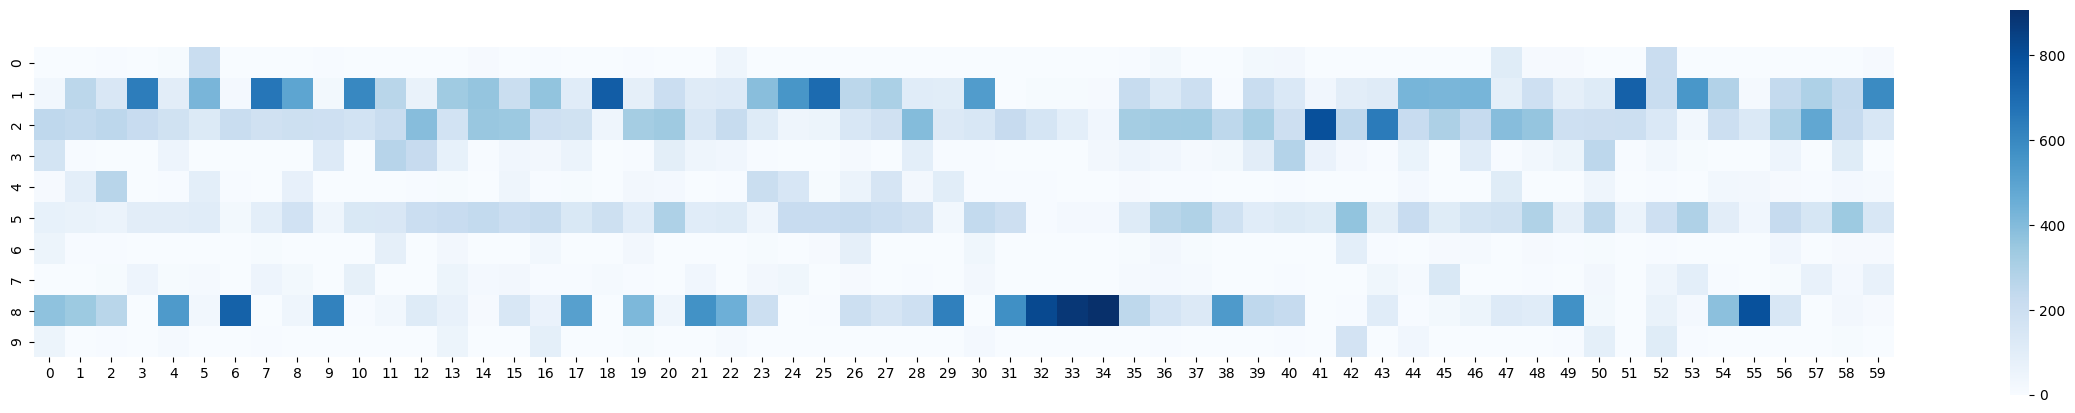

In [57]:
fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(111)
seaborn.heatmap(confmat, square=True, ax=ax, cmap='Blues')
plt.show()
fig.savefig('/workspace/mnist_fractal_predict_confmat.png', dpi=300, pad_inches=0, bbox_inches='tight')

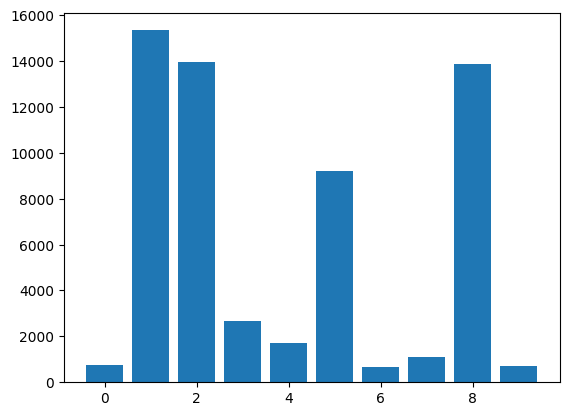

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(list(range(10)), np.sum(confmat, axis=1))
plt.show()
fig.savefig('/workspace/mnist_fractal_predict_sum.png', dpi=300, pad_inches=0, bbox_inches='tight')

In [62]:
n = 100
for i in range(n):
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(inputs[i].reshape(28,28), 'gray')
    ax1.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(list(range(10)), outputs[i])
    ax2.set_ylim((0.0, 1.0))
    fig.savefig(f'/workspace/sigsec/mnist_fractal_predict_im{i:0>3}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    # break
    plt.close()
# plt.show()

<Figure size 640x480 with 0 Axes>

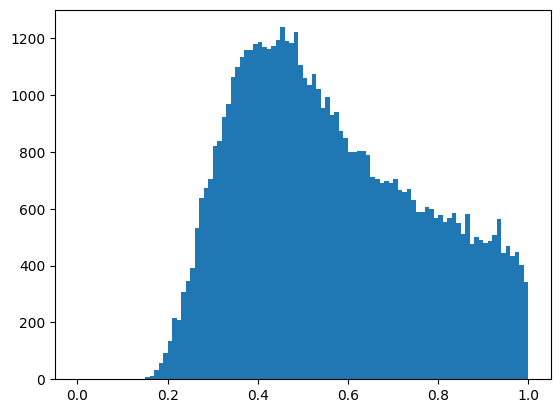

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(outputs.max(axis=1), bins=100, range=(0.0, 1.0))
plt.show()
fig.savefig(f'/workspace/mnist_fractal_confidence_max.png', dpi=300, pad_inches=0, bbox_inches='tight')